In [1]:
import gym
import numpy as np
import inventory_model
import pandas as pd
from evaluate import *
from ppo_evaluate import ppo_evaluate
import matplotlib.pyplot as plt


from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
#wrapper for cont env with PPO, plot result for several steps
def ppo_eval_interval(p, L, t_t, n_iter, n_step, gae, learning_rate=0.0003):
    ContCONFIG = {'h': 1, 'p': p, 'L': L, 'lambda': 1}
    cont_env = make_vec_env('inventory_cont_config_fix_model-v0', n_envs=4, env_kwargs=ContCONFIG)
    print("Running PPO w/: p=", p, ", L=",L)
    cont_model = PPO(MlpPolicy, cont_env, verbose=0, gamma = 1, gae_lambda=gae,
                     learning_rate = learning_rate,use_sde = False, n_steps = n_step)
    env_eval = make_vec_env('inventory_cont_config_fix_model-v0', n_envs=1, env_kwargs=ContCONFIG)
    timesteps = 0
    numiter = n_iter#test
    res_mean_arr = []
    res_std_arr = []

    while(timesteps <= t_t):

        cont_model.learn(total_timesteps=2*4*n_step-1)#each iteration has 8192 timesteps with n_env=4
        timesteps = timesteps + 2*4*n_step

        res_mean, res_std = ppo_evaluate(cont_model, env_eval, numiter)
        res_mean_arr.append(-res_mean)
        res_std_arr.append(res_std)
        
        if -res_mean == min(res_mean_arr):
            cont_model.save("ppo_min_model")
        
#         print(res_mean_arr)
    
    plt.plot(res_mean_arr)
    plt.xlabel("Iteration")
    plt.ylabel("Average cost")
    plt.title("L="+str(L)+", p="+str(p))
    
    min_model = PPO.load("ppo_min_model")
    mean_min, std_min = ppo_evaluate(min_model, env_eval, 10000)
    print("p="+str(p)+"， L="+str(L)+": mean "+str(-mean_min)+", std_dev: "+str(std_min))
    
    return res_mean_arr, res_std_arr, mean_min, std_min

Running PPO w/: p= 9 , L= 1


TypeError: bad operand type for unary +: 'str'

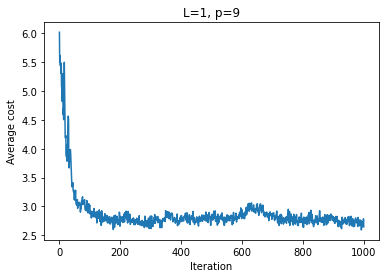

In [4]:
# listp = [0.25,1,4,9,39,99]
# listL = [1,4,70,100]
listp = [9]
listL = [1]
# t_t = 100000
n_iter = 1000
gae_lambda = 0.95
# n_step = 8192
learning_rate = 0.0003
ppo_res = pd.DataFrame(columns = ['p','L','res_mean', 'res_std'])

for p in listp:
    for L in listL:
        n_step = 64*L 
        t_t = 2000*4*n_step
        res_mean, res_std, mean_min, std_min = ppo_eval_interval(p,L,t_t, n_iter, n_step, gae_lambda, learning_rate)
        ppo_res = ppo_res.append({'p': p, 'L':L, 'res_mean':mean_min, 'res_std': std_min}, ignore_index=True)

In [ ]:
ppo_res

In [ ]:
plt.plot(res_mean)

## Below is obsolete.